- Họ tên: Võ Nguyễn Hoàng Kim
- MSSV: 21127090

## <b> Import các thư viện và cài đặt hàm cần thiết </b>

In [1]:
# import thư viện
import numpy as np
import cv2      # cv2 install bản 3.x
import matplotlib.pyplot as plt

In [2]:
# đọc ảnh dưới dạng cường độ xám bằng cv2 với địa chỉ tương đối
grayImg = cv2.imread('Lenna.jpg', cv2.IMREAD_GRAYSCALE);

# hàm sử dụng để biểu diễn ảnh của 3 kết quả: ban đầu, được tự cài đặt, gọi thư viện
def plotToCompare(orgImg, myImg, libImg, t1 = 'Origin', t2 = 'My Algorithm', t3 = 'OPEN CV' ):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=1)

    plt.subplot(1, 3, 1)
    plt.title(t1)
    plt.imshow(orgImg, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title(t2)
    plt.imshow(myImg, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title(t3)
    plt.imshow(libImg, cmap='gray')
    plt.show()


## <b> 1. Color Transformation </b> #

- ### Probability Density Function-based mapping - Histogram Equalization  ###

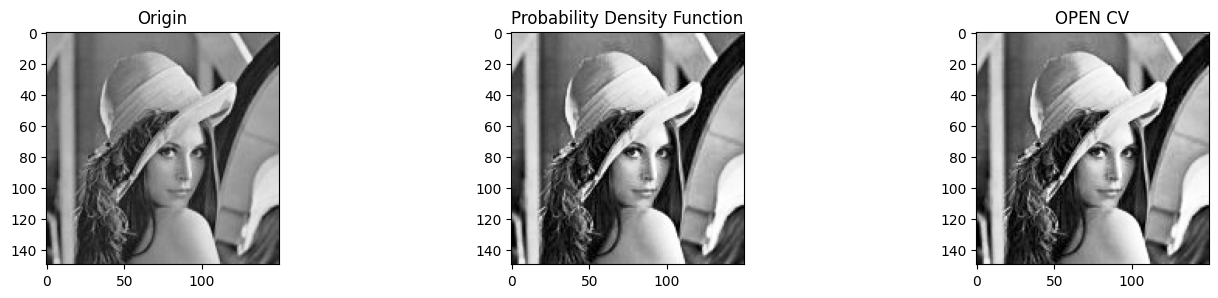

In [3]:
def probalityDensity(img_gray):
    n,m = img_gray.shape
    
    # Tìm kiếm nG levels (cấp mức xám có trong ảnh)
    nG = np.max(img_gray) + 1;

    # 1: Khởi tạp mảng H bắt đầu từ 0 có độ dài là nG
    hArr = np.zeros(nG, dtype=int);

    # 2: Đếm số mức xám của mỗi loại 
    for i in img_gray:
        for j in i:
            hArr[j] +=1;

    # 3: Lập biểu đồ image histogram, lưu vào T
    tArr = [];
    tArr.append(hArr[0]);
    for i in range(1,nG):
        val = tArr[i-1] + hArr[i]
        tArr.append(val);

    # 4: Chuẩn hóa Tr (Dựng bảng tra cứu T trong khoảng [0, nG-1])
    for i in range(0,nG):
        tArr[i] = round((nG-1)/(n*m) * tArr[i]);

    # 5: Xây dụng ảnh đầu ra
    resArr = img_gray.copy()
    for i in range(n):
        for j in range(m):
            val = resArr[i][j];
            resArr[i][j] = tArr[val]         
    return resArr

dst = cv2.equalizeHist(grayImg)

pdfImg = probalityDensity(grayImg)

# so sánh ảnh gốc, kết quả tự cài đặt, hàm gọi trong thư viện
plotToCompare(grayImg, pdfImg, dst, t2 = 'Probability Density Function')

- ### Linear mapping - Hàm tuyến tính  ###

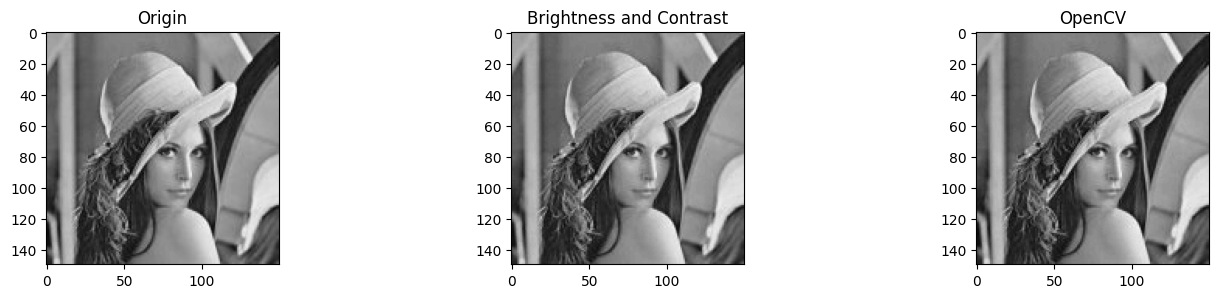

In [4]:
# thay đổi độ sáng
def brighnessModify(srcImg, beta):
    return np.clip(srcImg + beta, 0, 255).astype('uint8')

# thay đổi độ tương phản
def contrastModify(alpha, srcImg):
    return np.clip((srcImg*alpha), 0, 255).astype('uint')

# thay đổi kết hợp độ sáng và tương phản
def brightAndContrastModify(alpha, beta, srcImg):
    return brighnessModify(contrastModify(srcImg, alpha), beta) 

# ảnh được tạo từ thuật toán
brightAndContImg = brightAndContrastModify(0.3, 20, grayImg)

# ảnh được tạo với độ sáng là beta, độ tương phản alpha
cvtImg = cv2.convertScaleAbs(grayImg, alpha=0.3, beta=20)

# so sánh ảnh gốc, kết quả tự cài đặt, hàm gọi trong thư viện
plotToCompare(grayImg, brightAndContImg, cvtImg, t1 = 'Origin', t2 = 'Brightness and Contrast', t3 = 'OpenCV')

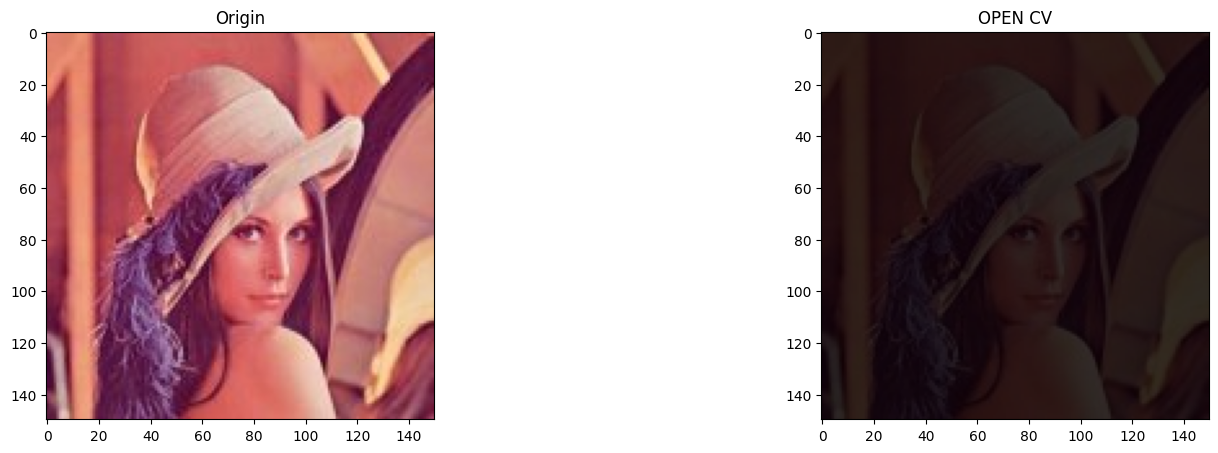

In [15]:
srcImg = cv2.imread('Lenna.jpg');
srcImg = cv2.cvtColor(srcImg, cv2.COLOR_BGR2RGB)
cvtImg = cv2.convertScaleAbs(srcImg, alpha= 0.2, beta=0)

def plot(orgImg, libImg, t1 = 'Origin', t3 = 'OPEN CV' ):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=1)

    plt.subplot(1, 2, 1)
    plt.title(t1)
    plt.imshow(orgImg, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(t3)
    plt.imshow(libImg, cmap='gray')
    plt.show()
    
plot(srcImg, cvtImg)


## <b>2. Geometry Transformation </b> #

- ### Linear interpolation  ##

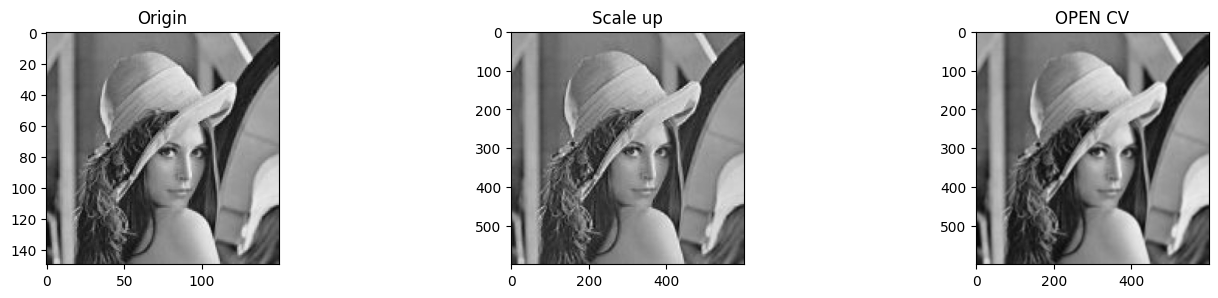

In [5]:
n,m = grayImg.shape

# ảnh sẽ được scale up / down theo chiều fx và fy dựa vào aX và aY
aX = 4;
aY = 4;
gSize = [round(aX*n), round(aY*m)];     # kích thước của ảnh đầu ra được tính từ hệ số trên

# Phép biến đổi T-1
def calcOrgCord(gX, gY, aX, aY):
    return(gX/aX, gY/aY)

# interpolation linear
def interLinear(fx, fy, grayImg):
    gSize = [round(fx*n), round(fy*m)];
    gArr = np.zeros((gSize[0], gSize[1]), dtype=int);
    
    # thay đổi kích thước ảnh trên hệ tọa độ
    for i in range(n):
        for j in range(m):
            x = round(i*fx);
            y = round(j*fy);
            if(x<gSize[0] and y<gSize[1]):
                gArr[x,y] = grayImg[i][j]
                
    # nội suy giá trị màu cho ảnh g(gX, gY) từ ảnh gốc f(fX, fY)
    for gX in range(gArr.shape[0]):     
        for gY in range(gArr.shape[1]):
            fX, fY = calcOrgCord(gX, gY, aX, aY)
            l = round(fX)
            k = round(fY)
            if(l >= n-1) : l=n-2
            if(k >= m-1) : k=n-2
            a = fX-l
            b = fY-k
            gArr[gX][gY] = round((1-a)*(1-b)*grayImg[l][k] + (1-b)*(a)*grayImg[l+1][k] + (1-a)*(b)*grayImg[l][k+1] 
                                 + a*b*grayImg[l+1][k+1])
    return np.clip(gArr, 0, 255).astype('uint8')

scaleImg = interLinear(aX, aY, grayImg)

# ảnh được tạo từ hàm thư viện với kích thước gSize 
dst = cv2.resize(grayImg, (gSize[0],gSize[1]), cv2.INTER_LINEAR)

# so sánh ảnh gốc, kết quả tự cài đặt, hàm gọi trong thư viện
plotToCompare(grayImg, scaleImg, dst ,t2= 'Scale up')    

## <b>3. Image Smoothing </b>

- ### Gaussian Filter 

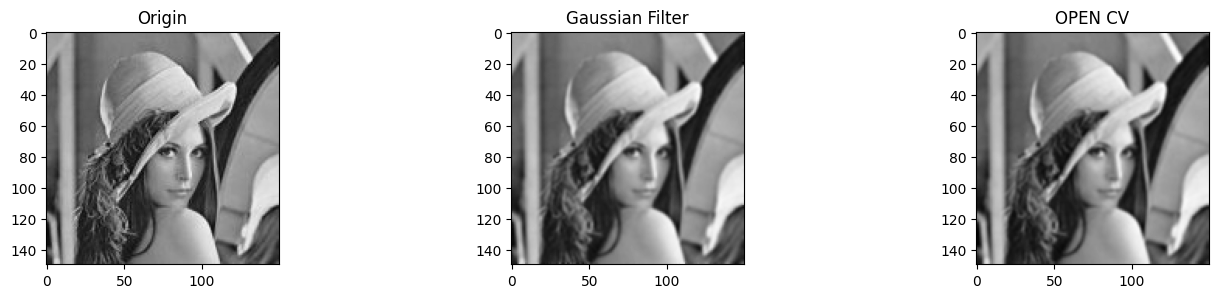

In [6]:
# sử dụng kernel với kích thước 3x3
GaussianKernel = np.array([[1,2,1],
                            [2,4,2],
                            [1,2,1]])/16

# xây dựng hàm với kích thước kernel cố định: 3X3
def gaussFilter(GaussianKernel, img): 
    blurImg = img.copy() 
    for i in range (1,img.shape[0]-1):
        for j in range (1,img.shape[1]-1):
            blurImg[i,j] = (img[i-1: i+2, j-1: j+2].astype('float64')*GaussianKernel).sum()
            
    return np.clip(blurImg, 0, 255).astype('uint8')

gaussImg = gaussFilter(GaussianKernel, grayImg)

# ảnh được tạo từ hàm thư viện với kích thước kernel là 3x3
Gblur = cv2.GaussianBlur(grayImg,(3,3),0)

# so sánh ảnh gốc, kết quả tự cài đặt, hàm gọi trong thư viện
plotToCompare(grayImg, gaussImg, Gblur, t2 = 'Gaussian Filter')

- ### Average Filter 

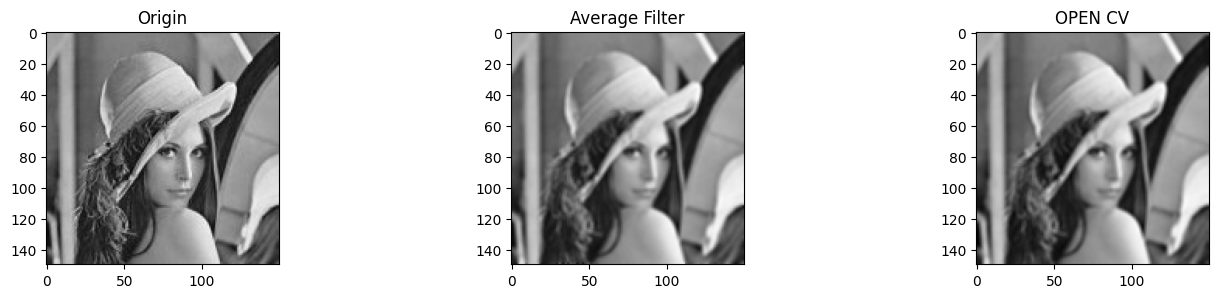

In [7]:
# sử dụng filter với kích thước 3x3
h = np.array([[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]])/9
    
# xây dựng hàm với kích thước filter cố định: 3x3
def avgFilter(hFilter, img):
    aveImg = img.copy()
    
    for i in range (1,img.shape[0]-1):
        for j in range (1,img.shape[1]-1):
            aveImg[i,j] = (img[i-1: i+2, j-1: j+2].astype('float64')*hFilter).sum()
    return np.clip(aveImg, 0, 255).astype('uint8')
avgImg = avgFilter(h, grayImg)

# ảnh được tạo từ hàm thư viện với kích thước filter là 3x3
avg = cv2.blur(grayImg, (3,3))

# so sánh ảnh gốc, kết quả tự cài đặt, hàm gọi trong thư viện
plotToCompare(grayImg, avgImg, avg, t2 = 'Average Filter')


- ### Median Filter 

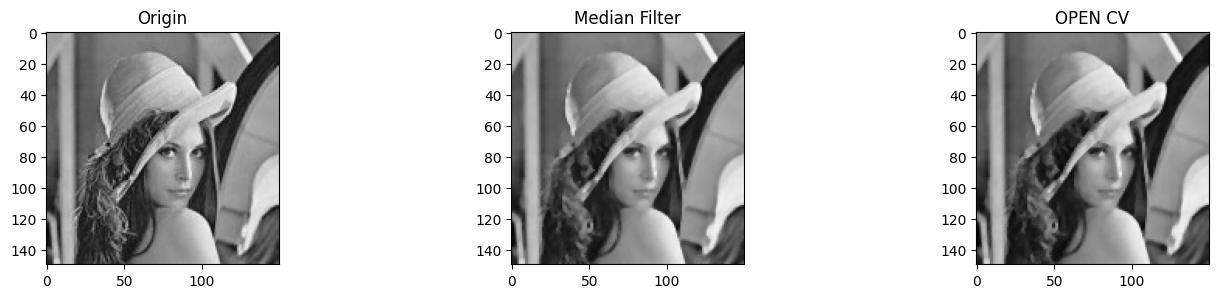

In [8]:
# xây dựng hàm với kích thước filter cố định: 3x3
def medFilter(grayImg):
    medArr = np.copy(grayImg);
    
    for i in range (1,grayImg.shape[0]-1):
        for j in range (1,grayImg.shape[1]-1):
            medElement = np.sort(np.array(grayImg[i-1: i+2, j-1: j+2]), axis=None)[4];
            medArr[i][j] = medElement;
    return medArr
medImg = medFilter(grayImg)

# ảnh được tạo từ hàm thư viện với kích thước filter là 3x3
med = cv2.medianBlur(grayImg, 3);

# so sánh ảnh gốc, kết quả tự cài đặt, hàm gọi trong thư viện
plotToCompare(grayImg, medImg, med, t2 = 'Median Filter')